In [1]:
!pip install kaggle

In [2]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d ravidussilva/real-ai-art

100% 9.95G/9.95G [08:46<00:00, 22.2MB/s]
100% 9.95G/9.95G [08:46<00:00, 20.3MB/s]


In [5]:
!unzip real-ai-art.zip

Streaming output truncated to the last 5000 lines.
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_114.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_116.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_142.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_154.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_183.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_186.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_201.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_219.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_230.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_274.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_279.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_286.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_3.jpg  
  inflating: Re

In [6]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import os
from torchvision.io import read_image

class AIArtBenchDataset(Dataset):
    def __init__(self, root, for_training=True, transforms=None, target_transforms=None):
        self.for_training = for_training
        self.transforms = transforms
        self.target_transforms = target_transforms

        if self.for_training:
            self.root = os.path.join(root, 'train')
        else:
            self.root = os.path.join(root, 'test')

        self.fnames_list = []
        for directory in os.listdir(self.root):
            for image in os.listdir(os.path.join(self.root, directory)):
                self.fnames_list.append(os.path.join(directory, image))

    def __len__(self):
        return len(self.fnames_list)

    def __getitem__(self, idx):

        img_name = self.fnames_list[idx]
        img_path = os.path.join(self.root, img_name)
        image = read_image(img_path)

        if 'AI' in img_name:
            if 'SD' in img_name:
                label = 0 # 0 for standard diffusion art
            else:
                label = 1 # 1 for latent diffusion art
        else:
            label = 2 # 2 for real art

        if self.transforms:
            image = self.transforms(image)
        if self.target_transforms:
            label = self.target_transforms(label)

        return image, label

In [7]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.1 MB/s eta 0:00:00


In [8]:
import numpy as np
import random
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.transforms import Resize, Normalize, Compose, ToTensor, Lambda
import torchvision.transforms.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.Compose([
    Lambda(lambda x: x.float()),  # Convert images to float tensors
    transforms.Resize((299, 299)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Assuming AIArtBenchDataset is a custom dataset class
train_dataset = AIArtBenchDataset(root='/content/Real_AI_SD_LD_Dataset', for_training=True, transforms=transform)

# Set seed for reproducibility
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Using device: cuda:0


In [ ]:
#calcualate mean and STD of training:
import torch

# Variables to store sum and count for mean calculation
sums = torch.tensor([0.0, 0.0, 0.0])
squared_sums = torch.tensor([0.0, 0.0, 0.0])
count = 0

for data in train_dataset:
    image, _ = data
    image = image.float() / 255  # Convert to float and scale if necessary
    sums += image.sum(dim=[1, 2])  # Sum over height and width dimensions
    squared_sums += (image ** 2).sum(dim=[1, 2])
    count += image.size(1) * image.size(2)  # Accumulate total number of pixels

# Calculate mean and standard deviation
mean = sums / count
std_dev = torch.sqrt(squared_sums / count - mean ** 2)

print("Mean: ", mean)
print("Standard Deviation: ", std_dev)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Mean:  tensor([2.0954, 1.9562, 1.6198])
Standard Deviation:  tensor([1.1794, 1.1090, 1.1039])


In [9]:
from torch.utils.data import DataLoader
from torchvision import transforms

import torch
import timm
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss



model = timm.create_model('efficientnet_b4', pretrained=False, num_classes=3) #pretrained on imagenet
model = model.to(device)  # Move model to GPU if available

# Define loss function and optimizer
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

In [10]:
from tqdm import tqdm  # Import tqdm for the progress bar


In [ ]:

# Training loop
train_losses = []
val_losses = []
num_epochs = 5  # Set the number of epochs
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    with tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as train_bar:
      for images, labels in train_bar:
          images, labels = images.to(device), labels.to(device)  # Move tensors to GPU
          outputs = model(images)
          loss = criterion(outputs, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          train_loss += loss.item()
          train_losses.append(loss.item())  # Append loss for each iteration
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          # Update progress bar
          train_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    train_epoch_loss = train_loss / len(train_dataloader)
    train_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_dataloader)}, Accuracy: {train_accuracy}%')

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        with tqdm(val_dataloader, desc='Validation', unit='batch') as val_bar:
          for images, labels in val_bar:
              images, labels = images.to(device), labels.to(device)  # Move tensors to GPU
              outputs = model(images)
              loss = criterion(outputs, labels)

              val_loss += loss.item()
              val_losses.append(loss.item())  # Append loss for each iteration
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
              val_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    val_epoch_loss = val_loss / len(val_dataloader)
    val_accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss/len(val_dataloader)}, Validation Accuracy: {val_accuracy}%')

Epoch 1/5: 100%|██████████| 3876/3876 [23:49<00:00,  2.71batch/s, accuracy=91.2, loss=0.0107]


Epoch [1/5], Loss: 0.242610371598482, Accuracy: 91.18391768538528%


Validation: 100%|██████████| 969/969 [02:49<00:00,  5.70batch/s, accuracy=98.5, loss=0.0392]


Validation Loss: 0.043465942239124034, Validation Accuracy: 98.52594910169984%


Epoch 2/5: 100%|██████████| 3876/3876 [23:44<00:00,  2.72batch/s, accuracy=98.8, loss=7.94e-5]


Epoch [2/5], Loss: 0.04001505843354412, Accuracy: 98.75576557107377%


Validation: 100%|██████████| 969/969 [02:49<00:00,  5.71batch/s, accuracy=99.9, loss=0.00362]


Validation Loss: 0.005081212991778254, Validation Accuracy: 99.88710769925491%


Epoch 3/5: 100%|██████████| 3876/3876 [23:43<00:00,  2.72batch/s, accuracy=99.7, loss=6.56e-7]


Epoch [3/5], Loss: 0.012875338804448303, Accuracy: 99.65809760345773%


Validation: 100%|██████████| 969/969 [02:48<00:00,  5.75batch/s, accuracy=99.9, loss=3.34e-5]


Validation Loss: 0.0026628229937019896, Validation Accuracy: 99.94516659678095%


Epoch 4/5: 100%|██████████| 3876/3876 [23:47<00:00,  2.71batch/s, accuracy=99.8, loss=0.0236]


Epoch [4/5], Loss: 0.007474243724498707, Accuracy: 99.81130858304036%


Validation: 100%|██████████| 969/969 [02:51<00:00,  5.66batch/s, accuracy=99.9, loss=0.00297]


Validation Loss: 0.005614001942032965, Validation Accuracy: 99.90323517078993%


Epoch 5/5: 100%|██████████| 3876/3876 [23:48<00:00,  2.71batch/s, accuracy=99.8, loss=8.25e-5]


Epoch [5/5], Loss: 0.008337792434956325, Accuracy: 99.79840660581235%


Validation: 100%|██████████| 969/969 [02:51<00:00,  5.64batch/s, accuracy=99.1, loss=0.029]

Validation Loss: 0.02724975289329281, Validation Accuracy: 99.1226655484953%


In [ ]:
torch.save(model.state_dict(), 'efficient_model.pth')

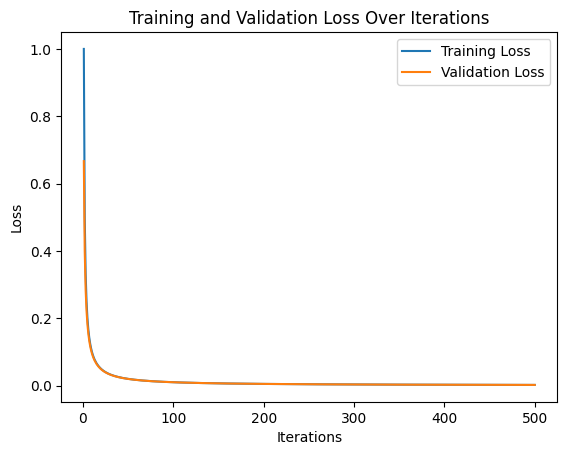

In [ ]:
import matplotlib.pyplot as plt

# Sample data for demonstration
iterations_per_epoch = 100  # Example number of iterations (batches) per epoch
num_epochs = 5  # Example number of epochs
total_iterations = iterations_per_epoch * num_epochs

# Create a list for the x-axis (iteration numbers)
iterations = list(range(1, total_iterations + 1))

# Sample training and validation losses for demonstration
train_losses = [1/x for x in range(1, total_iterations + 1)]
val_losses = [1/(x + 0.5) for x in range(1, total_iterations + 1)]

# Plotting the training and validation losses
plt.plot(iterations, train_losses, label='Training Loss')
plt.plot(iterations, val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Iterations')
plt.legend()
plt.show()


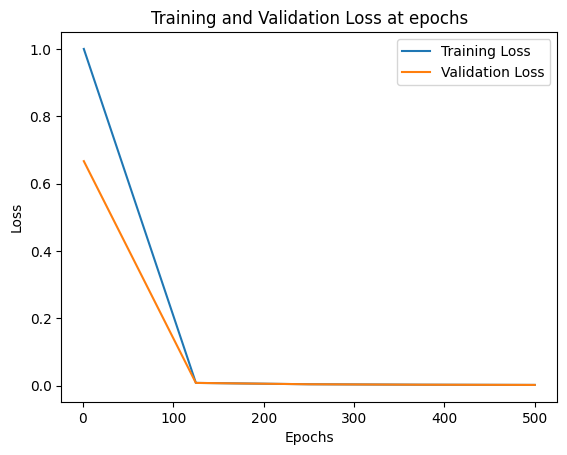

In [ ]:
import numpy as np

# Selecting 5 evenly spaced points from the iterations list
selected_points = np.linspace(1, total_iterations, 5, dtype=int)

# Filtering the losses to include only the selected points
filtered_train_losses = [train_losses[i-1] for i in selected_points]
filtered_val_losses = [val_losses[i-1] for i in selected_points]

# Plotting the filtered training and validation losses
plt.plot(selected_points, filtered_train_losses, label='Training Loss')
plt.plot(selected_points, filtered_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss at epochs')
plt.legend()
plt.show()


In [11]:
model.load_state_dict(torch.load('efficient_model.pth'))

<All keys matched successfully>

In [12]:
test_dataset = AIArtBenchDataset(root='/content/Real_AI_SD_LD_Dataset', for_training=False, transforms=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()  # Set model to evaluation mode
test_loss = 0.0
correct = 0
total = 0
test_predictions = []
true_labels = []

with torch.no_grad():
    # Test phase with tqdm for progress bar
    with tqdm(test_dataloader, desc='Testing', unit='batch') as test_bar:
        for images, labels in test_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            test_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

avg_test_loss = test_loss / len(test_dataloader)
test_accuracy = 100 * correct / total

print(f'\nTest Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Testing:   0%|          | 0/938 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Testing: 100%|██████████| 938/938 [04:49<00:00,  3.24batch/s, accuracy=99, loss=2.24e-8]


Test Loss: 0.0295, Test Accuracy: 98.98%


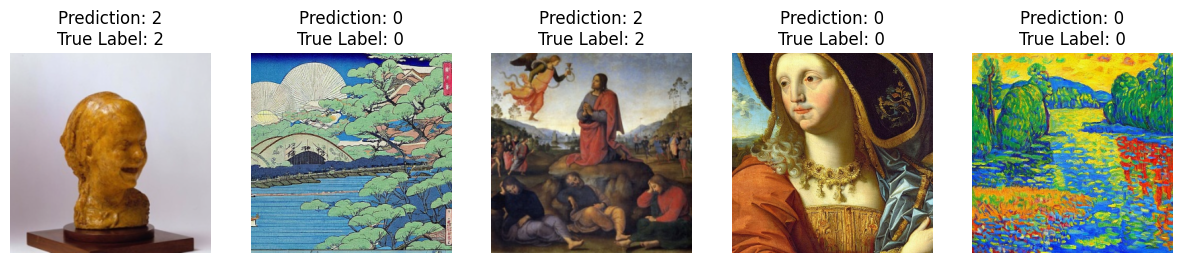

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torchvision.transforms.functional as F

# Function to display images with predictions and true labels
def display_images(images, predictions, true_labels, class_labels):
    plt.figure(figsize=(15, 7))
    for i in range(len(images)):
        # Convert PIL image to ndarray
        img_array = np.array(images[i])

        plt.subplot(1, 5, i + 1)
        plt.imshow(np.transpose(vutils.make_grid(torch.tensor(img_array), padding=2, normalize=True).cpu(), (1, 2, 0)))
        plt.title(f"Prediction: {class_labels[predictions[i].item()]}\nTrue Label: {class_labels[true_labels[i].item()]}")
        plt.axis('off')
    plt.show()

# Choose 5 random samples from the test set
sample_indices = np.random.choice(len(test_dataset), 5, replace=False)
sample_images = [test_dataset[i][0] for i in sample_indices]
sample_labels = [test_dataset[i][1] for i in sample_indices]

# Convert predictions and true labels to NumPy arrays for indexing
sample_predictions = np.array(test_predictions)[sample_indices]
sample_true_labels = np.array(true_labels)[sample_indices]

# Display the images with predictions and true labels
display_images(sample_images, sample_predictions, sample_true_labels, class_labels=["0", "1", "2"])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


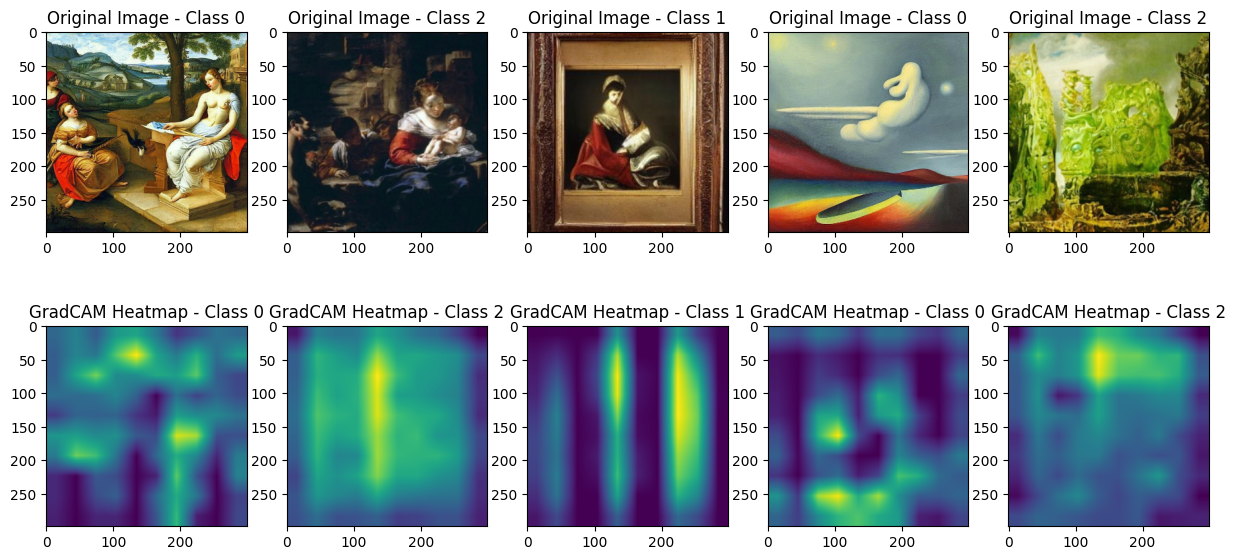

In [14]:
import cv2
import numpy as np
import torchvision.transforms as transforms
from torch.autograd import Function

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.model.eval()
        self.feature_maps = None
        self.gradient = None
        self.hooks = []

        self._register_hooks()

    def _register_hooks(self):
        def hook_fn(module, input, output):
            self.feature_maps = output.detach()

        self.hooks.append(self.target_layer.register_forward_hook(hook_fn))

        def backward_hook_fn(module, grad_input, grad_output):
            self.gradient = grad_output[0].detach()

        self.hooks.append(self.target_layer.register_backward_hook(backward_hook_fn))

    def forward(self, x):
        return self.model(x)

    def backward(self, output, target_class):
        self.model.zero_grad()
        one_hot_output = torch.zeros_like(output)
        one_hot_output[0][target_class] = 1.0
        output.backward(gradient=one_hot_output, retain_graph=True)

    def generate(self, input_image, target_class, size=(299, 299)):
        input_image = input_image.unsqueeze(0)
        output = self.forward(input_image)

        self.backward(output, target_class)

        weights = torch.mean(self.gradient, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.feature_maps, dim=1, keepdim=True)
        cam = torch.nn.functional.relu(cam)

        cam = torch.nn.functional.interpolate(cam, size=size, mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()

        return cam

# Sample indices and images
sample_indices = np.random.choice(len(test_dataset), 5, replace=False)
sample_images = [test_dataset[i][0] for i in sample_indices]
sample_labels = [test_dataset[i][1] for i in sample_indices]

# Initialize GradCAM
target_layer = None
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        target_layer = module

# Check if the target layer is found
if target_layer is None:
    raise ValueError("No Conv2D layer found in the model")

# Initialize GradCAM with the target layer
gradcam = GradCAM(model, target_layer=target_layer)


# Plot original image and GradCAM heatmap
plt.figure(figsize=(15, 7))

for i in range(5):
    # Original Image
    plt.subplot(2, 5, i + 1)
    img_array = np.array(sample_images[i])
    plt.imshow(np.transpose(vutils.make_grid(torch.tensor(img_array), padding=2, normalize=True).cpu(), (1, 2, 0)))
    plt.title(f'Original Image - Class {sample_labels[i]}')

    # GradCAM Heatmap
    plt.subplot(2, 5, i + 6)
    label = sample_labels[i]  # Assuming the label is set correctly
    heatmap = gradcam.generate(sample_images[i].to(device), target_class=label)
    plt.imshow(heatmap, cmap='viridis')
    plt.title(f'GradCAM Heatmap - Class {label}')

plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_f

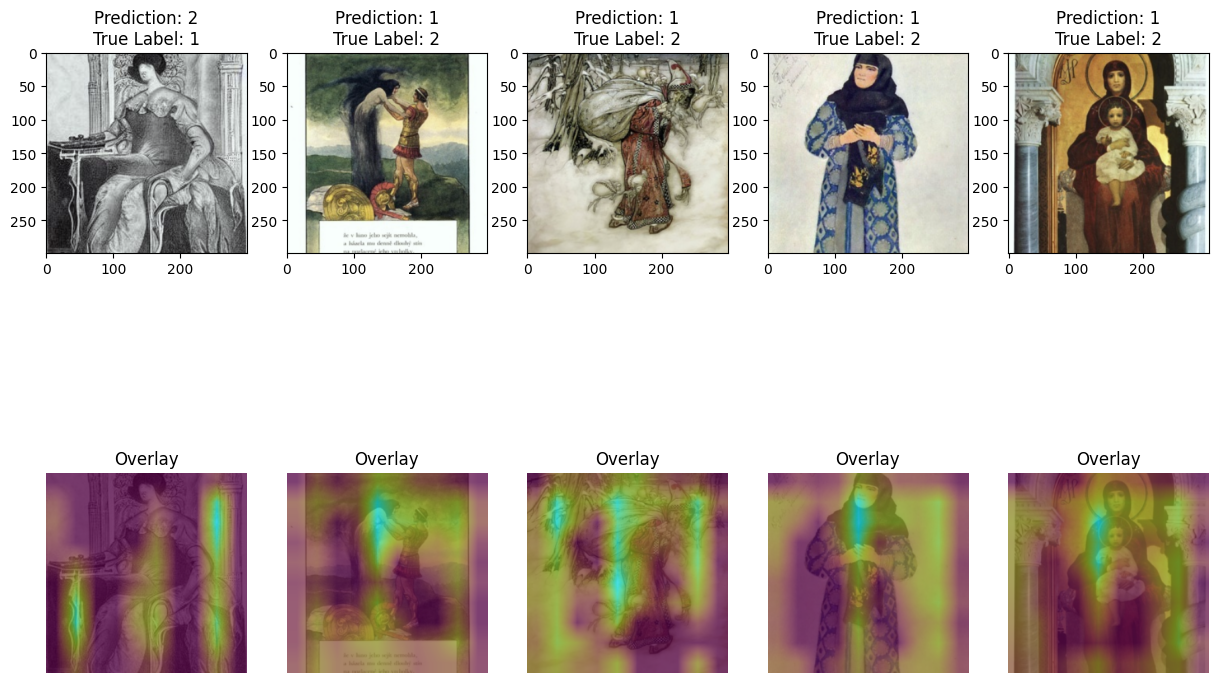

In [17]:
# Function to overlay GradCAM heatmap on the original image
def overlay_heatmap(original_img, heatmap):
    # Normalize heatmap values
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + 1e-8)

    # Apply colormap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_VIRIDIS)

    # Convert original image to uint8 if it's not already
    original_img = (original_img.numpy()*255).astype(np.uint8)
    # original_img = np.transpose(original_img, (1, 2, 0))

    # Overlay images
    overlaid_img = cv2.addWeighted(original_img, 0.25, heatmap, 0.75, 0)

    return overlaid_img

# Identify Misclassified Images
misclassified_indices = [i for i, (pred, true) in enumerate(zip(test_predictions, true_labels)) if pred != true]
misclassified_images = [test_dataset[i][0] for i in misclassified_indices]
misclassified_predictions = [test_predictions[i] for i in misclassified_indices]
misclassified_true_labels = [true_labels[i] for i in misclassified_indices]

# Display Misclassified Images with Predictions, True Labels, and Heatmaps
def display_misclassified_images_with_heatmaps(images, predictions, true_labels, class_labels):
    plt.figure(figsize=(15, 10))
    for i, image in enumerate(images):
        image_index = i % 5 + 1  # This ensures the index is between 1 and 5
        heatmap_index = image_index + 5  # This places the heatmap in the second row
        # Original Image
        plt.subplot(2, 5, image_index)
        img_array = np.array(image)
        img = np.transpose(vutils.make_grid(torch.tensor(img_array), padding=2, normalize=True).cpu(), (1, 2, 0))
        plt.imshow(img)
        plt.title(f"Prediction: {class_labels[predictions[i]]}\nTrue Label: {class_labels[true_labels[i]]}")

        # GradCAM Heatmap
        plt.subplot(2, 5, heatmap_index)

        label = true_labels[i]  # Use true label for GradCAM
        heatmap = gradcam.generate(image.to(device), target_class=label)
        # plt.imshow(heatmap, cmap='viridis')
        # plt.title(f'GradCAM Heatmap - Class {class_labels[label]}')
        overlaid_img = overlay_heatmap(img, heatmap)
        plt.axis('off')
        plt.imshow(overlaid_img)
        plt.title(f'Overlay')


    plt.show()

# Display the misclassified images with their heatmaps
display_misclassified_images_with_heatmaps(misclassified_images, misclassified_predictions, misclassified_true_labels, class_labels=["0", "1", "2"])


In [ ]:
misclassified_indices


[934,
 3009,
 3083,
 3135,
 3161,
 3176,
 3218,
 3219,
 3223,
 3264,
 3296,
 3300,
 3319,
 3337,
 3356,
 3362,
 3372,
 3396,
 3423,
 3452,
 3477,
 3486,
 3579,
 3583,
 3591,
 3663,
 3690,
 3705,
 3716,
 3747,
 3748,
 3770,
 3811,
 3835,
 3855,
 3876,
 3914,
 3989,
 4069,
 4107,
 4108,
 4238,
 4299,
 4302,
 4431,
 4442,
 4517,
 4521,
 4549,
 4556,
 4662,
 4739,
 4888,
 4951,
 6007,
 6009,
 6028,
 6044,
 6067,
 6173,
 6207,
 6241,
 6467,
 6488,
 6582,
 6621,
 6632,
 6655,
 6689,
 6693,
 6699,
 6711,
 6730,
 6801,
 6807,
 7014,
 7047,
 7099,
 7157,
 7170,
 7196,
 7223,
 7334,
 7361,
 7367,
 7389,
 7402,
 7410,
 7417,
 7453,
 7520,
 7521,
 7525,
 7537,
 7582,
 7639,
 7662,
 7756,
 7822,
 7863,
 7941,
 7983,
 10042,
 10045,
 10048,
 10055,
 10056,
 10102,
 10103,
 10156,
 10158,
 10172,
 10214,
 10280,
 10307,
 10329,
 10336,
 10350,
 10354,
 10384,
 10419,
 10438,
 10439,
 10469,
 10515,
 10545,
 10556,
 10619,
 10665,
 10750,
 10776,
 10806,
 10890,
 10916,
 10918,
 10993,
 14004,
 14023,